<a href="https://colab.research.google.com/github/BagusAth/e-commerce-review-sentiment-analysis/blob/main/Capstone_Project_Bagus_Athallah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalasi library yang diperlukan
!pip install transformers accelerate bitsandbytes datasets -q

print("✅ Instalasi Selesai")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.5 MB/s eta 0:00:00
✅ Instalasi Selesai


In [2]:
from huggingface_hub import login
import getpass

try:
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
    login(token=HF_TOKEN)
except ImportError:
    print("Masukkan Hugging Face Token Anda:")
    HF_TOKEN = getpass.getpass()
    login(token=HF_TOKEN)

print("✅ Login Berhasil")

✅ Login Berhasil


In [3]:
from datasets import load_dataset
import pandas as pd

dataset_name = "yelp_review_full"
dataset = load_dataset(dataset_name)

print("Struktur Dataset:")
print(dataset)
print("\nContoh data ulasan:")
contoh_data = dataset['train'][0]
print(f"Teks: {contoh_data['text']}")
print(f"Label Asli: {contoh_data['label']} (0-4 mewakili 1-5 bintang)")

def convert_label_to_stars(label_id):
    return f"{label_id + 1} Star"

print(f"Label Terkonversi: {convert_label_to_stars(contoh_data['label'])}")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Struktur Dataset:
DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

Contoh data ulasan:
Teks: dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.
Label Asli: 4 (0-4 mewakili 1-5 bintang)
Label Terkonversi: 5 Star


In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "ibm-granite/granite-3.3-2b-instruct"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

print("✅ Model dan Tokenizer berhasil dimuat!")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

✅ Model dan Tokenizer berhasil dimuat!


In [9]:
def klasifikasi_sentimen(review_text):
    prompt = f"""
Task: Classify the sentiment of the following review.
Your answer MUST be a single word: Positive, Negative, Neutral, or Mixed.

Review: "{review_text}"
Sentiment:"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=5,
        temperature=0.1
    )
    result_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    raw_output = result_text.split("Sentiment:")[-1].strip()
    clean_output = raw_output.split()[0].strip()

    return clean_output

# --- Uji Coba ---
ulasan_contoh = "The movie was great in the beginning, but the ending was terrible."
print(f"Review: '{ulasan_contoh}'")
print(f"Predicted Sentiment: {klasifikasi_sentimen(ulasan_contoh)}")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Review: 'The movie was great in the beginning, but the ending was terrible.'
Predicted Sentiment: Mixed.


In [6]:
def buat_ringkasan(review_text):
    prompt = f"""
Summarize the following review in one concise sentence.

Review: "{review_text}"
Summary:"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=50,
        temperature=0.2
    )

    result_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    final_result = result_text.split("Summary:")[-1].strip()

    return final_result

# --- Uji Coba ---
ulasan_panjang_en = "Initially, I was hesitant to buy this, but I'm so glad I did. The build quality is excellent, all the features work as advertised, and it looks great. Customer service was also very helpful when I had a question. A fantastic product overall."

print(f"Original Review: '{ulasan_panjang_en}'")
print(f"Generated Summary: {buat_ringkasan(ulasan_panjang_en)}")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original Review: 'Initially, I was hesitant to buy this, but I'm so glad I did. The build quality is excellent, all the features work as advertised, and it looks great. Customer service was also very helpful when I had a question. A fantastic product overall.'
Generated Summary: The reviewer is pleased with the product's build quality, functionality, appearance, and customer service, considering it a fantastic purchase.

No changes are made to the original sentence. The summary accurately captures the main points of the review


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Starting sentiment classification for 30 reviews...


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignore

✅ Classification process finished.

Comparison of Original Stars and Predicted Sentiment:
                                                text original_stars  \
0  dr. goldberg offers everything i look for in a...         5 Star   
1  Unfortunately, the frustration of being Dr. Go...         2 Star   
2  Been going to Dr. Goldberg for over 10 years. ...         4 Star   
3  Got a letter in the mail last week that said D...         4 Star   
4  I don't know what Dr. Goldberg was like before...         1 Star   

  predicted_sentiment  
0            Positive  
1            Negative  
2            Positive  
3            Negative  
4            Negative  


/tmp/ipython-input-1864685064.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis", ax=ax)


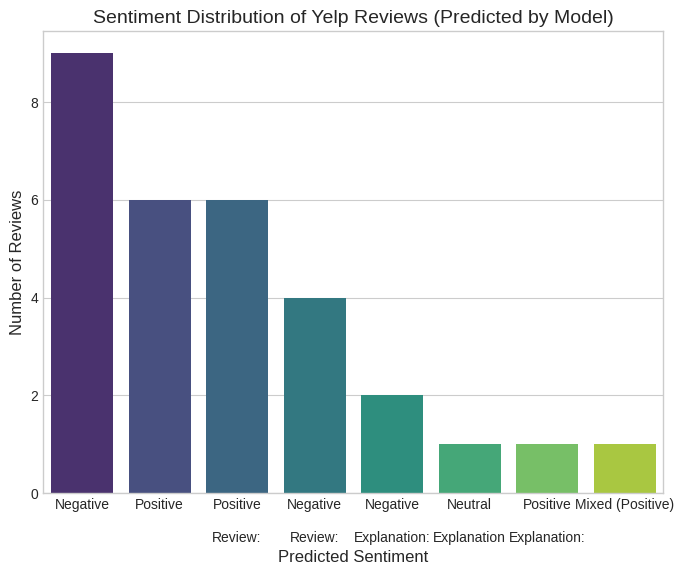


Initial Insight from Model's Prediction:
predicted_sentiment
Negative                    9
Positive                    6
Positive\n\nReview:         6
Negative\n\nReview:         4
Negative\n\nExplanation:    2
Neutral\n\nExplanation      1
Positive\n\nExplanation:    1
Mixed (Positive)            1
Name: count, dtype: int64


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ambil sampel data untuk dianalisis (30 ulasan pertama)
sample_size = 30
data_sampel = dataset['train'].select(range(sample_size))
df = pd.DataFrame(data_sampel)
print(f"Starting sentiment classification for {sample_size} reviews...")
df['predicted_sentiment'] = df['text'].apply(klasifikasi_sentimen)
print("✅ Classification process finished.")

# Mengubah kolom 'label' asli menjadi teks bintang
df['original_stars'] = df['label'].apply(convert_label_to_stars)

# Menampilkan hasil dalam tabel untuk perbandingan
print("\nComparison of Original Stars and Predicted Sentiment:")
print(df[['text', 'original_stars', 'predicted_sentiment']].head())

# --- Membuat Visualisasi dari hasil prediksi model ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

# Hitung jumlah setiap sentimen dari kolom prediksi
sentiment_counts = df['predicted_sentiment'].value_counts()

# Bar plot
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis", ax=ax)

ax.set_title('Sentiment Distribution of Yelp Reviews (Predicted by Model)', fontsize=14)
ax.set_xlabel('Predicted Sentiment', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)

plt.show()

print("\nInitial Insight from Model's Prediction:")
print(sentiment_counts)

--- Hasil Setelah Dibersihkan dan Dikelompokkan ---
kategori_bersih
Negative    15
Positive    13
Neutral      1
Mixed        1
Name: count, dtype: int64


/tmp/ipython-input-2157421764.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_counts.index, y=final_counts.values, palette="viridis", ax=ax)


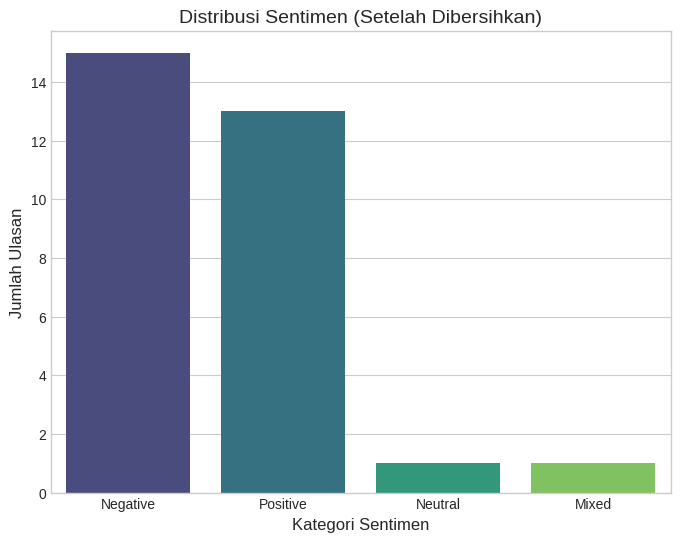

In [10]:
def bersihkan_kategori(kategori_prediksi):
    kategori = str(kategori_prediksi).lower().strip()
    if 'mixed' in kategori:
        return 'Mixed'
    elif 'positive' in kategori:
        return 'Positive'
    elif 'negative' in kategori:
        return 'Negative'
    elif 'neutral' in kategori:
        return 'Neutral'
    else:
        return 'Unknown'

df['kategori_bersih'] = df['predicted_sentiment'].apply(bersihkan_kategori)

print("--- Hasil Setelah Dibersihkan dan Dikelompokkan ---")
final_counts = df['kategori_bersih'].value_counts()
print(final_counts)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(x=final_counts.index, y=final_counts.values, palette="viridis", ax=ax)

ax.set_title('Distribusi Sentimen (Setelah Dibersihkan)', fontsize=14)
ax.set_xlabel('Kategori Sentimen', fontsize=12)
ax.set_ylabel('Jumlah Ulasan', fontsize=12)
plt.show()

In [13]:
from IPython.display import display, Markdown

def generate_insights(counts):
    data_summary = "Berikut adalah hasil analisis sentimen dari 30 ulasan produk Yelp:\n"
    for category, count in counts.items():
        data_summary += f"- {category}: {count} ulasan\n"

    prompt = f"""
Task: You are a professional data analyst. Based on the following sentiment analysis data, write the "Insight & Findings" section for a business report.
The insights must be unique, logical, and comprehensive. Explain what these numbers mean from a business perspective. Provide at least 3 distinct insight points in a bulleted list.

Data:
{data_summary}

Insight & Findings:
"""
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        temperature=0.4,
        repetition_penalty=1.1
    )

    result_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    final_insight = result_text.split("Insight & Findings:")[-1].strip()

    return final_insight

print("🤖 Meminta AI untuk menghasilkan Insight & Findings...")
insight_hasil_ai = generate_insights(final_counts)
print("✅ Insight berhasil dibuat.")

display(Markdown("---"))
display(Markdown("## Insight & Findings (Dihasilkan oleh AI)"))
display(Markdown(insight_hasil_ai))

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Meminta AI untuk menghasilkan Insight & Findings...
✅ Insight berhasil dibuat.


---

## Insight & Findings (Dihasilkan oleh AI)

1. **Balanced Customer Feedback**: The data indicates a balanced distribution of reviews with 15 negative, 13 positive, 1 neutral, and 1 mixed. This suggests that customers have diverse experiences with product Y, ranging from satisfactory to dissatisfaction. A balanced feedback is generally positive as it signifies that the product meets or exceeds customer expectations in most cases, while also acknowledging areas for improvement.

2. **Potential for Product Improvement**: With 15 negative reviews outweighing the positive ones, there is an opportunity for product enhancement. These negative reviews may highlight specific pain points or dissatisfactions that need addressing. Analyzing these reviews can provide valuable insights into recurring issues, enabling targeted improvements to enhance overall customer satisfaction and loyalty.

3. **Engagement and Satisfaction Levels**: The presence of both positive (13) and negative (15) reviews implies varying levels of engagement and satisfaction among users. To capitalize on this, businesses should focus on understanding the reasons behind positive reviews to reinforce successful aspects and address concerns raised in negative reviews to mitigate dissatisfaction. This approach will help in crafting tai

In [14]:
from IPython.display import display, Markdown

def generate_recommendations(insights_text):
    prompt = f"""
Task: You are a senior business consultant. Your task is to write the final "Conclusion & Recommendation" section for a report.
Use ONLY the "Insight & Findings" provided below as your context.
The recommendations must be concrete, actionable, and have a clear potential impact on the business.

Provided Insight & Findings:
---
{insights_text}
---

Based on the insights above, generate the "Conclusion & Recommendation" section. Structure it with:
1. A "Conclusion" paragraph that summarizes the overall situation.
2. A bulleted list under "Recommendations" with at least 3 actionable points.

Conclusion & Recommendation:
"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=300,
        temperature=0.5,
        repetition_penalty=1.1
    )

    result_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    final_recommendation = result_text.split("Conclusion & Recommendation:")[-1].strip()

    return final_recommendation

if 'insight_hasil_ai' in locals():
    print("🤖 Meminta AI untuk menghasilkan Conclusion & Recommendation...")
    rekomendasi_hasil_ai = generate_recommendations(insight_hasil_ai)
    print("✅ Rekomendasi berhasil dibuat.")
    display(Markdown("---"))
    display(Markdown("## Conclusion & Recommendation (Dihasilkan oleh AI)"))
    display(Markdown(rekomendasi_hasil_ai))
else:
    print("⚠️ Harap jalankan sel 'Insight & Findings' terlebih dahulu untuk menghasilkan insight.")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Meminta AI untuk menghasilkan Conclusion & Recommendation...
✅ Rekomendasi berhasil dibuat.


---

## Conclusion & Recommendation (Dihasilkan oleh AI)

---

In conclusion, the analysis of customer feedback reveals a complex picture of product Y's performance, marked by a mix of positive, negative, neutral, and mixed reviews. While the majority of customers seem satisfied (13 positive and 1 neutral/mixed), the prevalence of negative reviews (15) underscores significant room for improvement. These negative reviews serve as critical feedback channels, highlighting potential product shortcomings and areas requiring attention.

**Recommendations:**

1. Conduct a thorough analysis of negative reviews to identify common themes and recurring issues. Prioritize these findings to develop targeted solutions addressing the core concerns of dissatisfied customers.

2. Leverage the success factors highlighted in positive reviews (13 in number) to strengthen marketing strategies and enhance brand positioning. Reinforcing these positive aspects can boost customer confidence and loyalty.

3. Implement a robust feedback loop system to continuously gather, analyze, and act upon customer reviews. This proactive strategy ensures ongoing product refinement, enhances customer satisfaction, and fosters long-term business growth.

By following these recommendations, the company can effectively navigate the current feedback landscape, turning negative perceptions into opportunities for improvement and solidifying its market position through consistent quality delivery.